# Model Learning on Dataset from a Simulated Experiment

In this notebook, we will use a dataset from a simulated experiment, more specifically, the `Simulated_calibration.ipynb` example notebook and perform Model Learning on a simple 1 qubit model.

### Imports

In [1]:
!pip install pandas matplotlib

import pickle
from pprint import pprint
import copy
import numpy as np
import os
import ast
import hjson
import pandas as pd

from c3.model import Model as Mdl
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.generator.generator import Generator as Gnr
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.generator.devices as devices
import c3.libraries.hamiltonians as hamiltonians
import c3.signal.pulse as pulse
import c3.libraries.envelopes as envelopes
import c3.libraries.tasks as tasks
from c3.optimizers.modellearning import ModelLearning
from c3.optimizers.sensitivity import Sensitivity

     |████████████████████████████████| 11.7 MB 10.2 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 63.6 MB/s eta 0:00:01


2022-05-18 12:39:44.780091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 12:39:44.780128: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## The Dataset

We first take a look below at the dataset and its properties. To explore more details about how the dataset is generated, please refer to the `Simulated_calibration.ipynb` example notebook.

In [2]:
DATAFILE_PATH = "data/small_dataset.pkl"

In [3]:
with open(DATAFILE_PATH, "rb+") as file:
    data = pickle.load(file)

2022-05-18 12:39:47.252246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-18 12:39:47.252292: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-18 12:39:47.252315: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (knecht): /proc/driver/nvidia/version does not exist
2022-05-18 12:39:47.252678: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
data.keys()

dict_keys(['seqs_grouped_by_param_set', 'opt_map'])

Since this dataset was obtained from an ORBIT ([arXiv:1403.0035](https://arxiv.org/abs/1403.0035)) calibration experiment, we have the `opt_map` which will tell us about the gateset parameters being optimized.

In [5]:
data["opt_map"]

[['rx90p[0]-d1-gauss-amp',
  'ry90p[0]-d1-gauss-amp',
  'rx90m[0]-d1-gauss-amp',
  'ry90m[0]-d1-gauss-amp'],
 ['rx90p[0]-d1-gauss-delta',
  'ry90p[0]-d1-gauss-delta',
  'rx90m[0]-d1-gauss-delta',
  'ry90m[0]-d1-gauss-delta'],
 ['rx90p[0]-d1-gauss-freq_offset',
  'ry90p[0]-d1-gauss-freq_offset',
  'rx90m[0]-d1-gauss-freq_offset',
  'ry90m[0]-d1-gauss-freq_offset'],
 ['id[0]-d1-carrier-framechange']]

This `opt_map` implies the calibration experiment focussed on optimizing 
the amplitude, delta and frequency offset of the gaussian pulse, along 
with the framechange angle

Now onto the actual measurement data from the experiment runs

In [6]:
seqs_data = data["seqs_grouped_by_param_set"]

**How many experiment runs do we have?**

In [7]:
len(seqs_data)

41

**What does the data from each experiment look like?**

We take a look at the first data point

In [8]:
example_data_point = seqs_data[0]

In [9]:
example_data_point.keys()

dict_keys(['params', 'seqs', 'results', 'results_std', 'shots'])

These `keys` are useful in understanding the structure of the dataset. We look at them one by one.

In [10]:
example_data_point["params"]

[450.000 mV, -1.000 , -50.500 MHz 2pi, 4.084 rad]

These are the parameters for our parameterised gateset, for the first experiment run. They correspond to the optimization parameters we previously discussed. 

The `seqs` key stores the sequence of gates that make up this ORBIT calibration experiment. Each ORBIT sequence consists of a set of gates, followed by a measurement operation. This is then repeated for some `n` number of shots (eg, `1000` in this case) and we only store the averaged result along with the standard deviation of these readout shots. Each experiment in turn consists of a number of these ORBIT sequences. The terms *sequence*, *set* and *experiment* are used somewhat loosely here, so we show below what these look like.

**A single ORBIT sequence**

In [11]:
example_data_point["seqs"][0]

['ry90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90m[0]',
 'ry90p[0]',
 'ry90p[0]',
 'rx90p[0]',
 'ry90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'ry90p[0]',
 'rx90m[0]',
 'rx90p[0]',
 'rx90p[0]',
 'ry90p[0]',
 'ry90p[0]',
 'rx90p[0]',
 'ry90p[0]',
 'ry90m[0]',
 'rx90p[0]',
 'rx90p[0]',
 'ry90m[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]']

**Total number of ORBIT sequences in an experiment**

In [12]:
len(example_data_point["seqs"])

20

**Total number of Measurement results**

In [13]:
len(example_data_point["results"])

20

**The measurement results and the standard deviation look like this**

In [14]:
example_results = [
    (example_data_point["results"][i], example_data_point["results_std"][i])
    for i in range(len(example_data_point["results"]))
]

In [15]:
pprint(example_results)

[([0.745], [0.013783141876945182]),
 ([0.213], [0.012947239087929134]),
 ([0.137], [0.0108734079294396]),
 ([0.224], [0.013184233007649706]),
 ([0.434], [0.015673034167001616]),
 ([0.105], [0.009694070352540258]),
 ([0.214], [0.012969348480166613]),
 ([0.112], [0.009972762907038352]),
 ([0.318], [0.014726710426975877]),
 ([0.122], [0.010349685985574633]),
 ([0.348], [0.015063067416698366]),
 ([0.122], [0.010349685985574633]),
 ([0.558], [0.01570464899321217]),
 ([0.186], [0.01230463327369004]),
 ([0.096], [0.009315793041926168]),
 ([0.368], [0.015250442616527561]),
 ([0.146], [0.011166198995181842]),
 ([0.121], [0.010313049985334118]),
 ([0.748], [0.013729384545565035]),
 ([0.692], [0.01459917805905524])]


## The Model for Model Learning

An initial model needs to be provided, which we refine by fitting to our calibration data. We do this below. If you want to learn more about what the various components of the model mean, please refer back to the `two_qubits.ipynb` notebook or the documentation.

### Define Constants

In [16]:
lindblad = False
dressed = True
qubit_lvls = 3
freq = 5.001e9
anhar = -210.001e6
init_temp = 0
qubit_temp = 0
t_final = 7e-9  # Time for single qubit gates
sim_res = 100e9
awg_res = 2e9
sideband = 50e6
lo_freq = 5e9 + sideband

### Model

In [17]:
q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(
        value=freq,
        min_val=4.995e9,
        max_val=5.005e9,
        unit="Hz 2pi",
    ),
    anhar=Qty(
        value=anhar,
        min_val=-250e6,
        max_val=-150e6,
        unit="Hz 2pi",
    ),
    hilbert_dim=qubit_lvls,
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit="K"),
)

drive = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive,
)
phys_components = [q1]
line_components = [drive]

init_ground = tasks.InitialiseGround(
    init_temp=Qty(value=init_temp, min_val=-0.001, max_val=0.22, unit="K")
)
task_list = [init_ground]
model = Mdl(phys_components, line_components, task_list)
model.set_lindbladian(lindblad)
model.set_dressed(dressed)

### Generator

In [18]:
generator = Gnr(
    devices={
        "LO": devices.LO(name="lo", resolution=sim_res, outputs=1),
        "AWG": devices.AWG(name="awg", resolution=awg_res, outputs=1),
        "DigitalToAnalog": devices.DigitalToAnalog(
            name="dac", resolution=sim_res, inputs=1, outputs=1
        ),
        "Response": devices.Response(
            name="resp",
            rise_time=Qty(value=0.3e-9, min_val=0.05e-9, max_val=0.6e-9, unit="s"),
            resolution=sim_res,
            inputs=1,
            outputs=1,
        ),
        "Mixer": devices.Mixer(name="mixer", inputs=2, outputs=1),
        "VoltsToHertz": devices.VoltsToHertz(
            name="v_to_hz",
            V_to_Hz=Qty(value=1e9, min_val=0.9e9, max_val=1.1e9, unit="Hz/V"),
            inputs=1,
            outputs=1,
        ),
    },
    chains={
        "d1": {
            "LO": [],
            "AWG": [],
            "DigitalToAnalog": ["AWG"],
            "Response": ["DigitalToAnalog"],
            "Mixer": ["LO", "Response"],
            "VoltsToHertz": ["Mixer"]
        },
    }
)

### Gateset

In [19]:
gauss_params_single = {
    "amp": Qty(value=0.45, min_val=0.4, max_val=0.6, unit="V"),
    "t_final": Qty(
        value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"
    ),
    "sigma": Qty(value=t_final / 4, min_val=t_final / 8, max_val=t_final / 2, unit="s"),
    "xy_angle": Qty(value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"),
    "freq_offset": Qty(
        value=-sideband - 0.5e6,
        min_val=-60 * 1e6,
        max_val=-40 * 1e6,
        unit="Hz 2pi",
    ),
    "delta": Qty(value=-1, min_val=-5, max_val=3, unit=""),
}

gauss_env_single = pulse.EnvelopeDrag(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=gauss_params_single,
    shape=envelopes.gaussian_nonorm,
)
nodrive_env = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"
        )
    },
    shape=envelopes.no_drive,
)
carrier_parameters = {
    "freq": Qty(
        value=lo_freq,
        min_val=4.5e9,
        max_val=6e9,
        unit="Hz 2pi",
    ),
    "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
}
carr = pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params=carrier_parameters,
)

rx90p = gates.Instruction(
    name="rx90p", t_start=0.0, t_end=t_final, channels=["d1"], targets=[0]
)
QId = gates.Instruction(
    name="id", t_start=0.0, t_end=t_final, channels=["d1"], targets=[0]
)

rx90p.add_component(gauss_env_single, "d1")
rx90p.add_component(carr, "d1")
QId.add_component(nodrive_env, "d1")
QId.add_component(copy.deepcopy(carr), "d1")
QId.comps["d1"]["carrier"].params["framechange"].set_value(
    (-sideband * t_final) % (2 * np.pi)
)
ry90p = copy.deepcopy(rx90p)
ry90p.name = "ry90p"
rx90m = copy.deepcopy(rx90p)
rx90m.name = "rx90m"
ry90m = copy.deepcopy(rx90p)
ry90m.name = "ry90m"
ry90p.comps["d1"]["gauss"].params["xy_angle"].set_value(0.5 * np.pi)
rx90m.comps["d1"]["gauss"].params["xy_angle"].set_value(np.pi)
ry90m.comps["d1"]["gauss"].params["xy_angle"].set_value(1.5 * np.pi)

### Experiment

In [20]:
parameter_map = PMap(
    instructions=[QId, rx90p, ry90p, rx90m, ry90m], model=model, generator=generator
)

exp = Exp(pmap=parameter_map)

In [21]:
exp_opt_map = [[('Q1', 'anhar')], [('Q1', 'freq')]]
exp.pmap.set_opt_map(exp_opt_map)

## Optimizer 

In [22]:
datafiles = {"orbit": DATAFILE_PATH} # path to the dataset
run_name = "simple_model_learning" # name of the optimization run
dir_path = "ml_logs" # path to save the learning logs
algorithm = "cma_pre_lbfgs" # algorithm for learning
# this first does a grad-free CMA-ES and then a gradient based LBFGS
options = {
    "cmaes": {
        "popsize": 12,
        "init_point": "True",
        "stop_at_convergence": 10,
        "ftarget": 4,
        "spread": 0.05,
        "stop_at_sigma": 0.01,
    },
    "lbfgs": {"maxfun": 50, "disp": 0},
} # options for the algorithms
sampling = "high_std" # how data points are chosen from the total dataset
batch_sizes = {"orbit": 2} # how many data points are chosen for learning
state_labels = {
    "orbit": [
        [
            1,
        ],
        [
            2,
        ],
    ]
} # the excited states of the qubit model, in this case it is 3-level

In [23]:
opt = ModelLearning(
    datafiles=datafiles,
    run_name=run_name,
    dir_path=dir_path,
    algorithm=algorithm,
    options=options,
    sampling=sampling,
    batch_sizes=batch_sizes,
    state_labels=state_labels,
    pmap=exp.pmap,
)

opt.set_exp(exp)

## Model Learning

We are now ready to learn from the data and improve our model

In [24]:
opt.run()

C3:STATUS:Saving as: /home/ubuntu/c3/examples/ml_logs/simple_model_learning/2022_05_18_T_12_39_49/model_learn.log
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 2 (seed=971030, Wed May 18 12:39:49 2022)
C3:STATUS:Adding initial point to CMA sample.


/home/ubuntu/.local/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: input x0 should be a list or 1-D array, trying to flatten (2, 1)-array ()
  warnings.warn(msg + ' (' +


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     13 2.452509001838001e+00 1.0e+00 5.21e-02  5e-02  5e-02 0:45.0
termination on ftarget=4
final/bestever f-value = 2.452509e+00 2.452509e+00
incumbent solution: [-0.21640252950576294, 0.16553529166444397]
std deviation: [0.05017349381985182, 0.046069889679722614]
C3:STATUS:Saving as: /home/ubuntu/c3/examples/ml_logs/simple_model_learning/2022_05_18_T_12_39_49/confirm.log


### Result of Model Learning

In [25]:
opt.current_best_goal

-0.0316

In [26]:
print(opt.pmap.str_parameters(opt.pmap.opt_map))

Q1-anhar                              : -210.057 MHz 2pi 
Q1-freq                               : 5.000 GHz 2pi 



## Visualisation & Analysis of Results

The Model Learning logs provide a useful way to visualise the learning process and also understand what's going wrong (or right). We now process these logs to read some data points and also plot some visualisations of the Model Learning process

### Open, Clean-up and Convert Logfiles

In [27]:
LOGDIR = opt.logdir

In [28]:
logfile = os.path.join(LOGDIR, "model_learn.log")
with open(logfile, "r") as f:
    log = f.readlines()

In [29]:
params_names = [
    item for sublist in (ast.literal_eval(log[3].strip("\n"))) for item in sublist
]
print(params_names)

['Q1-anhar', 'Q1-freq']


In [30]:
data_list_dict = list()
for line in log[9:]:
    if line[0] == "{":
        temp_dict = ast.literal_eval(line.strip("\n"))
        for index, param_name in enumerate(params_names):
            temp_dict[param_name] = temp_dict["params"][index]
        temp_dict.pop("params")
        data_list_dict.append(temp_dict)

In [31]:
data_df = pd.DataFrame(data_list_dict)

### Summary of Logs

In [32]:
data_df.describe()

,goal,Q1-anhar,Q1-freq
count,21.000000,2.100000e+01,2.100000e+01
mean,8.677968,-2.099553e+08,5.000492e+09
std,15.468880,2.574355e+06,1.160692e+06
min,-0.031570,-2.138015e+08,4.995917e+09
25%,2.452509,-2.110718e+08,5.000200e+09
50%,5.276823,-2.100573e+08,5.000779e+09
75%,9.092966,-2.098452e+08,5.001000e+09
max,72.765614,-2.007295e+08,5.001524e+09


**Best Point**

In [33]:
best_point_file = os.path.join(LOGDIR, 'best_point_model_learn.log')

In [34]:
with open(best_point_file, "r") as f:
    best_point_log_dict = hjson.load(f)

best_point_dict = dict(zip(params_names, best_point_log_dict["optim_status"]["params"]))
best_point_dict["goal"] = best_point_log_dict["optim_status"]["goal"]
print(best_point_dict)

{'Q1-anhar': -210057285.72507972, 'Q1-freq': 5000081146.501029, 'goal': -0.031570491978972916}


### Plotting

We use `matplotlib` to produce the plots below. Please make sure you have the same installed in your python environment.

In [35]:
!pip install -q matplotlib

In [36]:
from matplotlib.ticker import MaxNLocator
from  matplotlib import rcParams
from matplotlib import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt 

In [37]:
rcParams["axes.grid"] = True
rcParams["grid.linestyle"] = "--"

# enable usetex by setting it to True if LaTeX is installed
rcParams["text.usetex"] = False
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"

**In the plots below, the blue line shows the progress of the parameter optimization while the black and the red lines indicate the converged and true value respectively**

### Qubit Anharmonicity

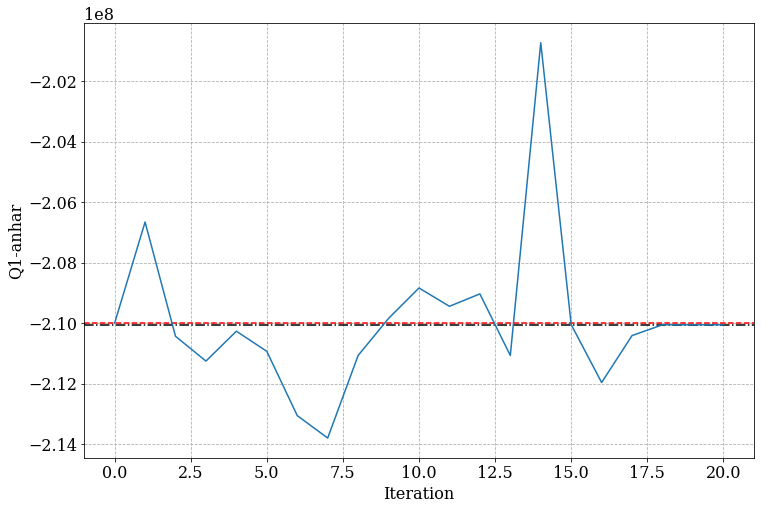

In [38]:
plot_item = "Q1-anhar"
true_value = -210e6

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Iteration")
ax.set_ylabel(plot_item)
ax.axhline(y=true_value, color="red", linestyle="--")
ax.axhline(y=best_point_dict[plot_item], color="black", linestyle="-.")
ax.plot(data_df[plot_item])

### Qubit Frequency

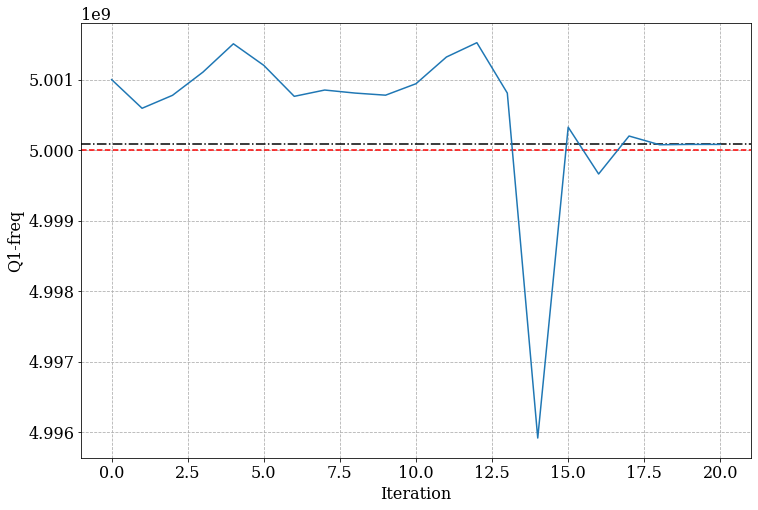

In [39]:
plot_item = "Q1-freq"
true_value = 5e9

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Iteration")
ax.set_ylabel(plot_item)
ax.axhline(y=true_value, color="red", linestyle="--")
ax.axhline(y=best_point_dict[plot_item], color="black", linestyle="-.")
ax.plot(data_df[plot_item])

### Goal Function

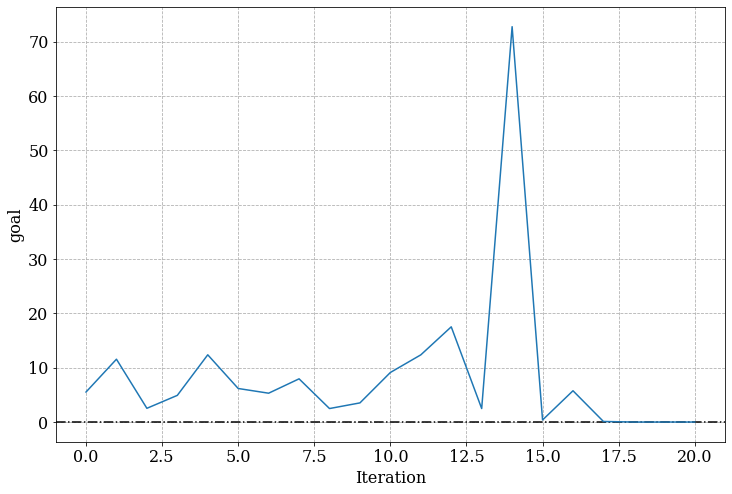

In [40]:
plot_item = "goal"

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Iteration")
ax.axhline(y=best_point_dict[plot_item], color="black", linestyle="-.")
ax.set_ylabel(plot_item)

ax.plot(data_df[plot_item])

# Sensitivity Analysis

Another interesting study to understand if our dataset is indeed helpful in improving certain model parameters is to perform a Sensitivity Analysis. The purpose of this exercise is to scan the Model Parameters of interest (eg, qubit frequency or anharmonicity) across a range of values and notice a prominent dip in the Model Learning Goal Function around the best-fit values

In [41]:
run_name = "Sensitivity"
dir_path = "sensi_logs"
algorithm = "sweep"
options = {"points": 20, "init_point": [-210e6, 5e9]}
sweep_bounds = [
    [-215e6, -205e6],
    [4.9985e9, 5.0015e9],
]

In [42]:
sense_opt = Sensitivity(
    datafiles=datafiles,
    run_name=run_name,
    dir_path=dir_path,
    algorithm=algorithm,
    options=options,
    sampling=sampling,
    batch_sizes=batch_sizes,
    state_labels=state_labels,
    pmap=exp.pmap,
    sweep_bounds=sweep_bounds,
    sweep_map=exp_opt_map,
)

sense_opt.set_exp(exp)

In [43]:
sense_opt.run()

C3:STATUS:Sweeping [['Q1-anhar']]: [-215000000.0, -205000000.0]
C3:STATUS:Saving as: /home/ubuntu/c3/examples/sensi_logs/Sensitivity/2022_05_18_T_12_42_19/sensitivity.log
C3:STATUS:Sweeping [['Q1-freq']]: [4998500000.0, 5001500000.0]
C3:STATUS:Saving as: /home/ubuntu/c3/examples/sensi_logs/Sensitivity/2022_05_18_T_12_43_33/sensitivity.log


## Anharmonicity

In [44]:
LOGDIR = sense_opt.logdir_list[0]

In [45]:
logfile = os.path.join(LOGDIR, "sensitivity.log")
with open(logfile, "r") as f:
    log = f.readlines()

In [46]:
data_list_dict = list()
for line in log[9:]:
    if line[0] == "{":
        temp_dict = ast.literal_eval(line.strip("\n"))
        param = temp_dict["params"][0]
        data_list_dict.append({"param": param, "goal": temp_dict["goal"]})

In [47]:
data_df = pd.DataFrame(data_list_dict)

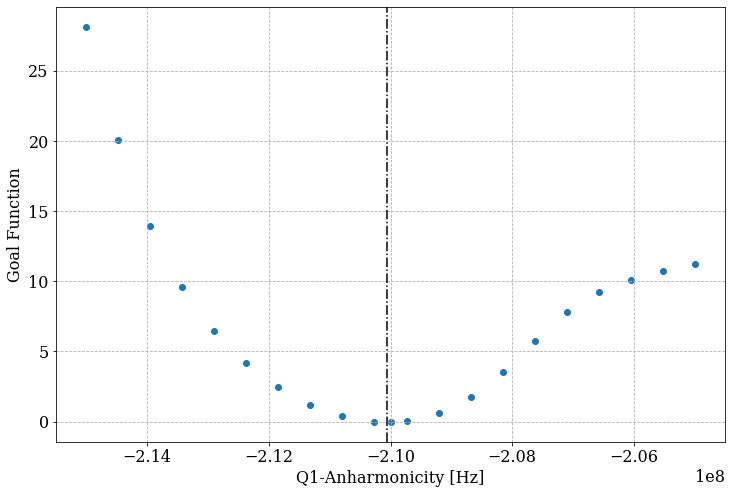

In [48]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Q1-Anharmonicity [Hz]")
ax.set_ylabel("Goal Function")
ax.axvline(x=best_point_dict["Q1-anhar"], color="black", linestyle="-.")
ax.scatter(data_df["param"], data_df["goal"])

## Frequency

In [49]:
LOGDIR = sense_opt.logdir_list[1]

In [50]:
logfile = os.path.join(LOGDIR, "sensitivity.log")
with open(logfile, "r") as f:
    log = f.readlines()

In [51]:
data_list_dict = list()
for line in log[9:]:
    if line[0] == "{":
        temp_dict = ast.literal_eval(line.strip("\n"))
        param = temp_dict["params"][0]
        data_list_dict.append({"param": param, "goal": temp_dict["goal"]})

In [52]:
data_df = pd.DataFrame(data_list_dict)

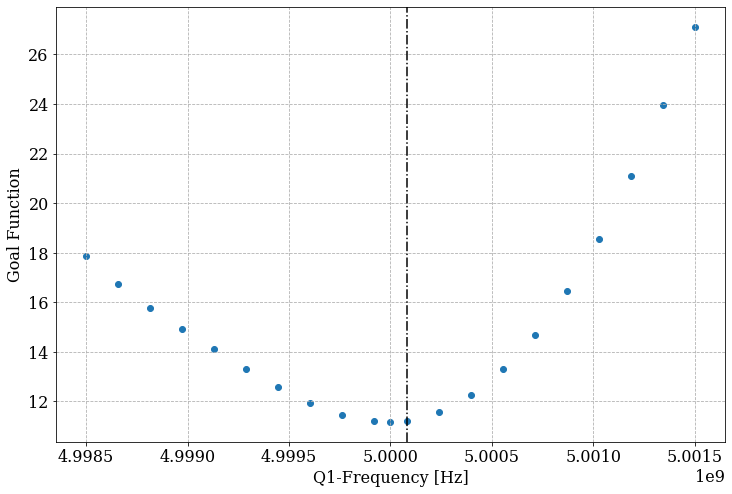

In [53]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Q1-Frequency [Hz]")
ax.set_ylabel("Goal Function")
ax.axvline(x=best_point_dict["Q1-freq"], color="black", linestyle="-.")
ax.scatter(data_df["param"], data_df["goal"])